In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook, trange, tqdm
from collections.abc import Iterable
from itertools import product
%matplotlib inline

In [164]:
matplotlib.rcParams.update({
    'font.size': 18,
})

In the numerical experiments we use a simulation model, implemented in Python language, and available at [GitHub](https://github.com/larioandr/2019-dccn-sensors).

Sensor mean uptime equal to 4000 hours is very large compared to typical 24-hours repair interval, so to simplify computations we assume by default that the mean uptime is equal to 720 hours (1 month). In other experiments we vary failure rate in such a way that mean uptime varies from a week to 4000 hours (approx. 5 months). 

For larger topologies we introduce one more assumption regarding repair time: we assume that the first repair interval (which takes places after a critical number of nodes turned off and the repair started for the first station) is 24 hours, while all successive repair intervals are 2 hours in average. This assumption is advocated by the fact that a repair team need much more time to visit a stock, take the equipment and get to the first station (especially in case of difficult terrains) and much less time to reach other failed sensors after repairing the first one.

We also assume by default that the network is considered unavailable when 2 or more sensors are offline, but for larger topologies with 20-30 sensors we extend the critical number of failed sensors to 4. As it will be shown, the effect of dynamic re-routing data by the sensors connected to the broken ones is especially clear in this case.

## 1. Sample topology validation

First of all, we run the numerical experiment on a slightly modified sample topology, shown on fig. \ref{XXX}. In contrast to previously defined sample topology (see section \ref{XXX} and fig. \ref{XXX}), here we assume that while the leaf node 4 is connected to a relay sensor 3, it can also reconnect to node 2 if sensor 3 becomes unavailable and dynamic routing is used.

In [6]:
FAILURE_RATE = 1/(24*30)  # 1 month - mean interval between failures 
REPAIR_RATE = 1/24        # 24 hours - mean repair duration
CRITICAL_FAILURES = 2     # 2 - number of offline nodes till critical error
SIM_TIME_LIMIT = 10*12*30*24  # experiment duration is 10 years

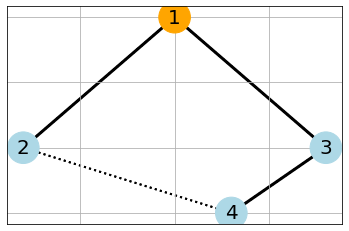

In [155]:
from senere.topology import Topology, GATEWAY_NODE, SENSOR_NODE
from senere.options import defaults as senere_defaults

senere_defaults['radio_range'] = 15.0  # This will simplify topology creation
senere_defaults['conn_line_width'] = 2.0
senere_defaults['neigh_line_width'] = 1.5

sample_topology = Topology()
sample_topology.nodes.add_from([
    {'address': 1, 'node_type': GATEWAY_NODE, 'x': 10.0, 'y': 25.0}, 
    {'address': 2, 'node_type': SENSOR_NODE, 'x': 2.0, 'y': 15.0},
    {'address': 3, 'node_type': SENSOR_NODE, 'x': 18.0, 'y': 15.0},
    {'address': 4, 'node_type': SENSOR_NODE, 'x': 13.0, 'y': 10.0},
])
sample_topology.connections.add_from([(3, 1), (2, 1), (4, 3)])

fig, ax = plt.subplots(figsize=(6, 4))
ax.grid()
sample_topology.draw(neigh_edges=True, node_size=1000, node_font_size=20, 
                     neigh_line_style=':', neigh_line_width=2, conn_line_width=3, gw_color='orange')
fig.savefig('images/basic_network.eps')

We analyze the stationary probability of the system failure, considering two scenarios:

1. after node 3 failure, node 4 doesn't reconnect to node 2, and
2. after node 3 failure, node 4 reconnects to node 2 (if it is available)

The results on measuring the system reliability in both cases are shown in fig. \ref{XXX}. It can be seen that dynamic routing slightly increases the reliability in case of short sensor uptime intervals, while for more reliable sensors with an average uptime of 1000 hours and more it doesn't make sense too much.

In [44]:
from senere.simulation import simulate_network


def variate_failure_rates(topology, mean_failure_intervals, num_runs=1, routing=None, 
                          repair_interval=None, cons_repair_interval=None, 
                          num_critical_errors=2, stime_limit=None):
    """Runs an experiment with a given topology on different failure intervals.
    
    `topology` parameter may be either a `Topology` object instance, or a callable which
    returns a topology. In the second case, a new topology is used at each run, and the
    value at each point is an average overall runs.
    
    `cons_repair_interval` specifies a callable which returns a consequetive repair interval.
    If given, it is passed to the simulation, if not - use only `repair_interval`.
    
    Returns: a dictionary with routing mode keys ('static', 'dynamic') and array values
    with experiment results, each point correspond to mean failure interval.
    """
    # 1) Create topologies
    try:
        topologies = [topology() for _ in range(num_runs)]
    except TypeError:
        topologies = [topology for _ in range(num_runs)]
    
    # 2) Define repair intervals and routing:
    routing_modes = [routing] if routing is not None else ['static', 'dynamic']
    repair_interval = repair_interval or (lambda: np.random.exponential(1 / REPAIR_RATE))
    cons_repair_interval = cons_repair_interval or repair_interval
    stime_limit = stime_limit or SIM_TIME_LIMIT
    
    # 3) Run the experiment:
    result = {}
    for mode in routing_modes:
        print(f'- simulating {mode} routing mode')
        avg_operable = []
        avg_num_offline = []
        avg_num_failed = []
        for mfi in tqdm_notebook(mean_failure_intervals, desc='Mean failure intervals'):
            failure_interval = lambda: np.random.exponential(mfi)
            operable = []
            num_offline_nodes = []
            num_failed_nodes = []
            if len(topologies) > 1:
                t_iter = tqdm_notebook(topologies, desc='Iterations', leave=False)
            else:
                t_iter = topologies
            for topology in t_iter:
                sim_ret = simulate_network(
                    topology, 
                    failure_interval=failure_interval, 
                    repair_interval=repair_interval,
                    cons_repair_interval=cons_repair_interval,
                    num_offline_till_repair=num_critical_errors,
                    routing_mode=mode,
                    stime_limit=stime_limit,
                )
                operable.append(sim_ret.operable)
                num_offline_nodes.append(sim_ret.num_offline_avg)
                num_failed_nodes.append(sim_ret.num_failed_avg)
                
            avg_operable.append(np.average(operable))
            avg_num_offline.append(np.average(num_offline_nodes))
            avg_num_failed.append(np.average(num_failed_nodes))
            
        result[mode] = {'operable': avg_operable, 'failed': avg_num_failed, 'offline': avg_num_offline}

    return result

In [45]:
MEAN_FAILURE_INTERVALS_1 = np.arange(4, 404, 5) * 24

exp_1a = variate_failure_rates(sample_topology, MEAN_FAILURE_INTERVALS_1)

- simulating static routing mode



- simulating dynamic routing mode


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


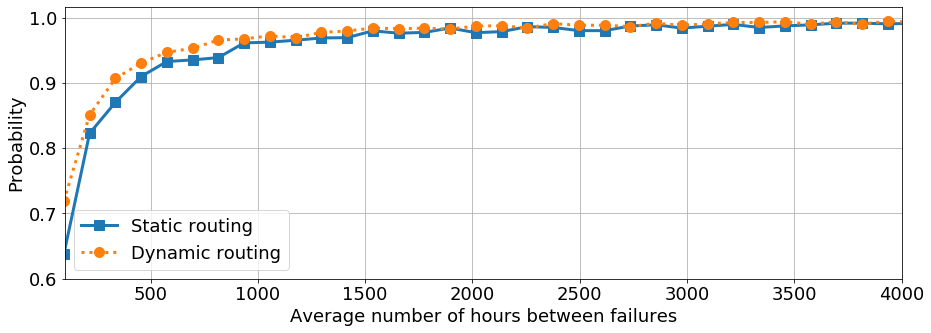

In [242]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(MEAN_FAILURE_INTERVALS_1, exp_1a['static']['operable'], 's-', linewidth=3, markersize=10,
        label='Static routing')
ax.plot(MEAN_FAILURE_INTERVALS_1, exp_1a['dynamic']['operable'], 'o:', linewidth=3, markersize=10,
        label='Dynamic routing')
ax.grid()
ax.legend()
# ax.set_title('Stationary uptime probability')
ax.set_xlabel('Average number of hours between failures')
ax.set_ylabel('Probability')
ax.set_xlim(left=100, right=4000)
ax.set_ylim(bottom=0.6)
fig.savefig('images/sample_topology_uptime.eps')
fig.savefig('images/sample_topology_uptime.png')


In [11]:
from senere.simulation import average_sample_traces


def estimate_failed_trace(topology, num_runs, sample_interval=10, routing=None, 
                          failure_interval=None, repair_interval=None, cons_repair_interval=None, 
                          num_critical_errors=2, stime_limit=None):
    """Record traces for failed and offline nodes number.
    """
    # 1) Define parameters    
    routing_modes = [routing] if routing is not None else ['static', 'dynamic']
    failure_interval = failure_interval or (lambda: np.random.exponential(1 / FAILURE_RATE))
    repair_interval = repair_interval or (lambda: np.random.exponential(1 / REPAIR_RATE))
    cons_repair_interval = cons_repair_interval or repair_interval
    stime_limit = stime_limit or SIM_TIME_LIMIT
    
    # 2) Run experiments
    result = {}
    for routing_mode in tqdm_notebook(routing_modes, desc='Routing modes'):
        offline_traces = []
        failed_traces = []
        for _ in trange(num_runs, desc='Iteration', leave=False):
            sim_ret = simulate_network(
                topology, 
                num_runs=1,
                record_samples=True,
                sample_interval=sample_interval,
                failure_interval=failure_interval, 
                repair_interval=repair_interval,
                cons_repair_interval=cons_repair_interval,
                num_offline_till_repair=num_critical_errors,
                routing_mode=routing_mode,
                stime_limit=stime_limit,
            )
            offline_traces.append(sim_ret.runs[0].data.num_offline_sampled)
            failed_traces.append(sim_ret.runs[0].data.num_failed_sampled)
            
        record = {
            'failed': average_sample_traces(failed_traces),
            'offline': average_sample_traces(offline_traces),
        }
        result[routing_mode] = record

    return result        

## 2. Forest topology

In the second experiment we study forest topologies, where a gateway is placed at the root of each tree.

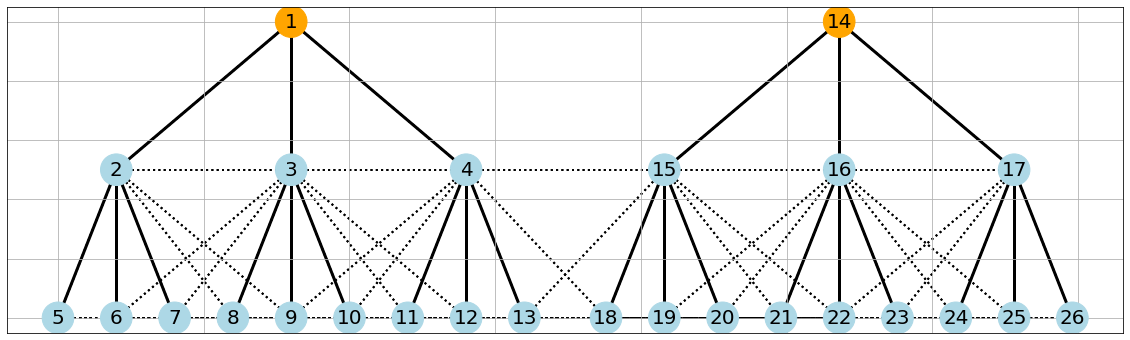

In [154]:
from senere.topology import build_forest_topology

sample_forest_3 = build_forest_topology(num_trees=2, arity=3, depth=2, dx=10, dy=50, roe=0.01, dt=14)

fig, ax = plt.subplots(figsize=(20, 6))
ax.grid()
sample_forest_3.draw(ax=ax, neigh_edges=True, node_size=1000, node_font_size=20, 
                     neigh_line_style=':', neigh_line_width=2, conn_line_width=3, gw_color='orange')
fig.savefig('images/ternary_forest.eps')

In [54]:
MEAN_FAILURE_INTERVALS_2 = np.arange(8, 168, 4) * 24
exp_2_3a = variate_failure_rates(sample_forest_3, MEAN_FAILURE_INTERVALS_2)

- simulating static routing mode



- simulating dynamic routing mode


In [55]:
exp_2_3b = variate_failure_rates(sample_forest_3, MEAN_FAILURE_INTERVALS_2, 
                                 cons_repair_interval=lambda: np.random.exponential(2.0))

- simulating static routing mode



- simulating dynamic routing mode


In [56]:
exp_2_3c = variate_failure_rates(sample_forest_3, MEAN_FAILURE_INTERVALS_2, 
                                 cons_repair_interval=lambda: np.random.exponential(2.0),
                                 num_critical_errors=4)

- simulating static routing mode



- simulating dynamic routing mode


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


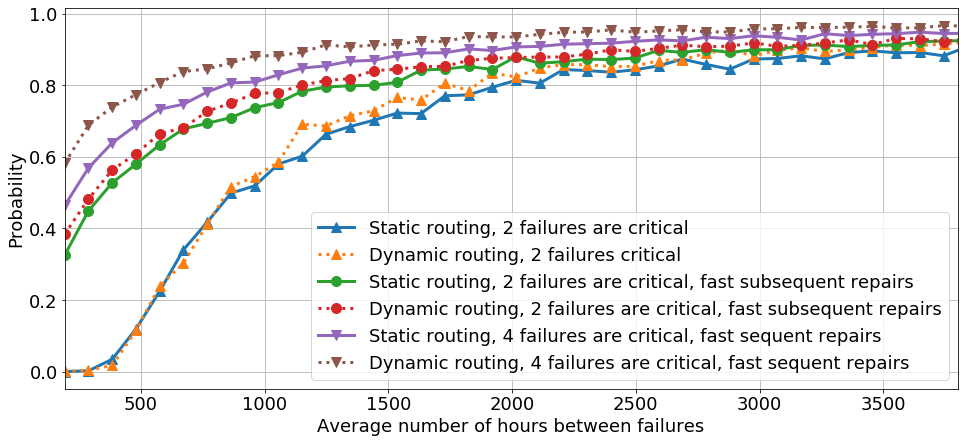

In [239]:
fig, ax = plt.subplots(figsize=(16, 7))
ax.plot(MEAN_FAILURE_INTERVALS_2, exp_2_3a['static']['operable'], '^-', linewidth=3, markersize=10,
        label='Static routing, 2 failures are critical')
ax.plot(MEAN_FAILURE_INTERVALS_2, exp_2_3a['dynamic']['operable'], '^:', linewidth=3, markersize=10,
        label='Dynamic routing, 2 failures critical')
ax.plot(MEAN_FAILURE_INTERVALS_2, exp_2_3b['static']['operable'], 'o-', linewidth=3, markersize=10,
        label='Static routing, 2 failures are critical, fast subsequent repairs')
ax.plot(MEAN_FAILURE_INTERVALS_2, exp_2_3b['dynamic']['operable'], 'o:', linewidth=3, markersize=10,
        label='Dynamic routing, 2 failures are critical, fast subsequent repairs')
ax.plot(MEAN_FAILURE_INTERVALS_2, exp_2_3c['static']['operable'], 'v-', linewidth=3, markersize=10,
        label='Static routing, 4 failures are critical, fast sequent repairs')
ax.plot(MEAN_FAILURE_INTERVALS_2, exp_2_3c['dynamic']['operable'], 'v:', linewidth=3, markersize=10,
        label='Dynamic routing, 4 failures are critical, fast sequent repairs')
ax.grid()
ax.legend(fontsize=18)
# ax.set_title('Stationary uptime probability')
ax.set_xlabel('Average number of hours between failures')
ax.set_ylabel('Probability')
ax.set_xlim(left=192, right=3800)
fig.savefig('images/ternary_forest_reliability.eps')
fig.savefig('images/ternary_forest_reliability.png')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


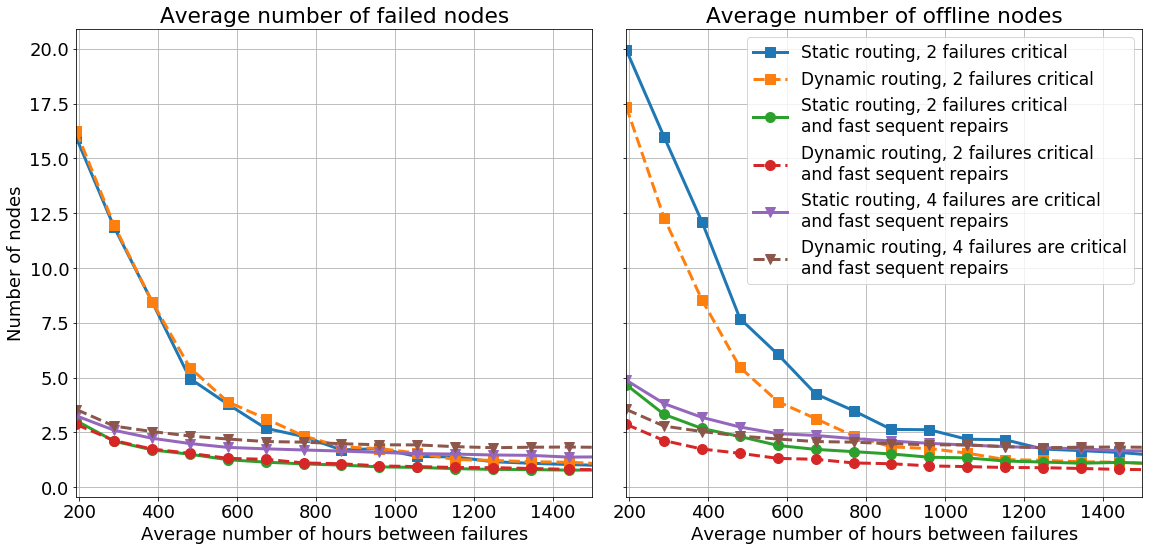

In [245]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(16, 8))
_lines = []
_labels = [
    'Static routing, 2 failures critical', 
    'Dynamic routing, 2 failures critical',
    'Static routing, 2 failures critical\nand fast sequent repairs',
    'Dynamic routing, 2 failures critical\nand fast sequent repairs',
    'Static routing, 4 failures are critical\nand fast sequent repairs',
    'Dynamic routing, 4 failures are critical\nand fast sequent repairs',
]
for ax, param in zip((ax1, ax2), ('failed', 'offline')):
    l1, = ax.plot(MEAN_FAILURE_INTERVALS_2, exp_2_3a['static'][param], 's-', linewidth=3, markersize=10)
    l2, = ax.plot(MEAN_FAILURE_INTERVALS_2, exp_2_3a['dynamic'][param], 's--', linewidth=3, markersize=10)
    l3, = ax.plot(MEAN_FAILURE_INTERVALS_2, exp_2_3b['static'][param], 'o-', linewidth=3, markersize=10)
    l4, = ax.plot(MEAN_FAILURE_INTERVALS_2, exp_2_3b['dynamic'][param], 'o--', linewidth=3, markersize=10) 
    l5, = ax.plot(MEAN_FAILURE_INTERVALS_2, exp_2_3c['static'][param], 'v-', linewidth=3, markersize=10)
    l6, = ax.plot(MEAN_FAILURE_INTERVALS_2, exp_2_3c['dynamic'][param], 'v--', linewidth=3, markersize=10) 
    ax.grid()
    ax.set_title(f'Average number of {param} nodes')
    ax.set_xlabel('Average number of hours between failures')
    ax.set_xlim(left=192, right=1500)
plt.tight_layout()
plt.legend([l1, l2, l3, l4, l5, l6], _labels, fontsize=17, loc='upper right')
ax1.set_ylabel('Number of nodes')
fig.savefig('images/ternary_forest_num_offline.eps')
fig.savefig('images/ternary_forest_num_offline.png')

In [38]:
exp_2_3d = estimate_failed_trace(sample_forest_3, 100, sample_interval=500)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


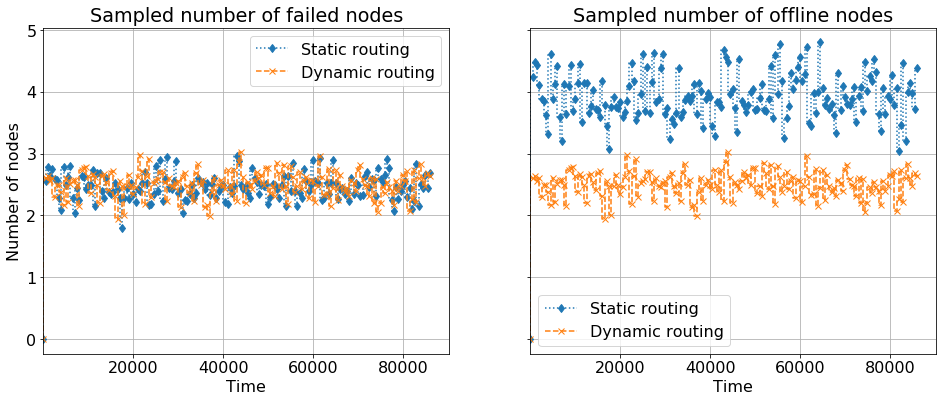

In [162]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 6), sharey=True)
ax1.step(*exp_2_3d['static']['failed'], 'd:', label='Static routing')
ax1.step(*exp_2_3d['dynamic']['failed'], 'x--', label='Dynamic routing')
ax2.step(*exp_2_3d['static']['offline'], 'd:', label='Static routing')
ax2.step(*exp_2_3d['dynamic']['offline'], 'x--', label='Dynamic routing')
ax1.grid()
ax2.grid()
ax1.legend()
ax2.legend()
ax1.set_title('Sampled number of failed nodes')
ax1.set_xlabel('Time')
ax1.set_ylabel('Number of nodes')
ax2.set_title('Sampled number of offline nodes')
ax2.set_xlabel('Time')
ax1.set_xlim(left=1)
ax2.set_xlim(left=1)
fig.savefig('images/ternary_forest_num_offline_dynamic.eps')
fig.savefig('images/ternary_forest_num_offline_dynamic.png')

## 3. Random topology

In the third experiment we consider completely random topologies.

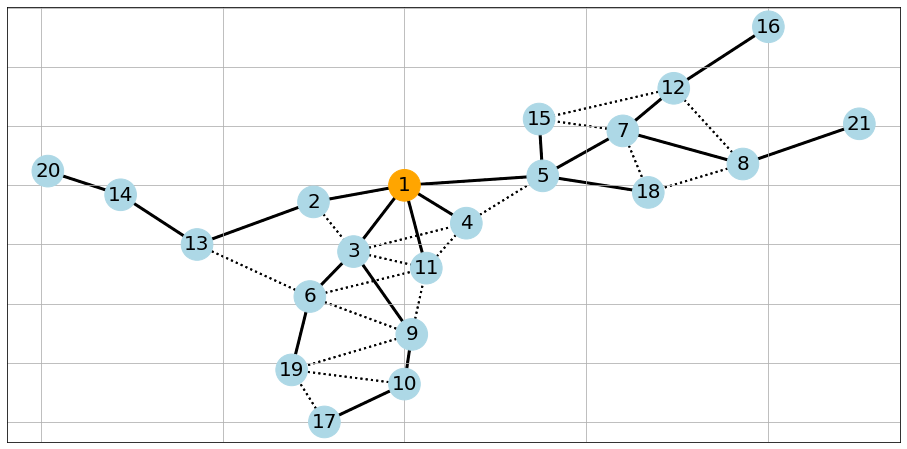

In [222]:
from senere.topology import build_random_topology


def random_topology(num_sensors=20, num_gw=1):
    return build_random_topology(num_gw, num_sensors, radio_range=40, min_distance=20, 
                                 min_gw_distance=30, max_gw_distance=60)

random_topology_example = random_topology(num_gw=1)
fig, ax = plt.subplots(figsize=(16, 8))
ax.grid()
random_topology_example.draw(ax=ax, neigh_edges=True, node_size=1000, node_font_size=20, 
                             neigh_line_style=':', neigh_line_width=2, conn_line_width=3, gw_color='orange')
fig.savefig('images/random_topology_example.eps')
fig.savefig('images/random_topology_example.png')

In [86]:
MEAN_FAILURE_INTERVALS_3 = np.arange(8, 168, 8) * 24

exp_3_1a = variate_failure_rates(
    lambda: random_topology(num_sensors=20, num_gw=1),
    MEAN_FAILURE_INTERVALS_3,
    num_runs=4,
    cons_repair_interval=lambda: np.random.exponential(2.0),
    num_critical_errors=4)

- simulating static routing mode



- simulating dynamic routing mode


In [90]:
exp_3_1b = variate_failure_rates(
    lambda: random_topology(num_sensors=20, num_gw=4),
    MEAN_FAILURE_INTERVALS_3,
    num_runs=4,
    cons_repair_interval=lambda: np.random.exponential(2.0),
    num_critical_errors=4)

- simulating static routing mode



- simulating dynamic routing mode


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


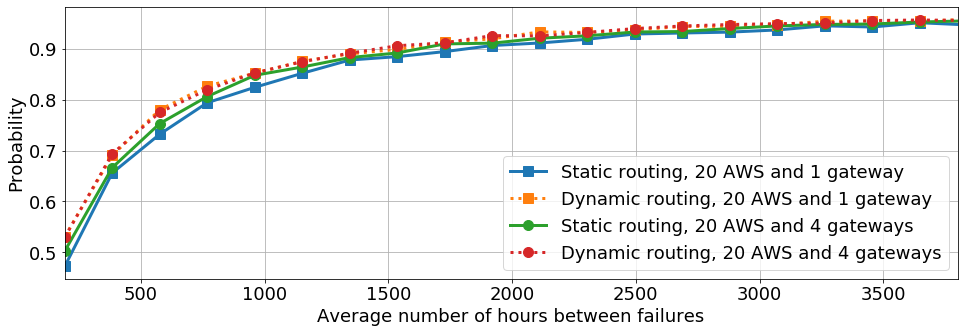

In [249]:
fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(MEAN_FAILURE_INTERVALS_3, exp_3_1a['static']['operable'], 's-', linewidth=3, markersize=10,
        label='Static routing, 20 AWS and 1 gateway')
ax.plot(MEAN_FAILURE_INTERVALS_3, exp_3_1a['dynamic']['operable'], 's:', linewidth=3, markersize=10,
        label='Dynamic routing, 20 AWS and 1 gateway')
ax.plot(MEAN_FAILURE_INTERVALS_3, exp_3_1b['static']['operable'], 'o-', linewidth=3, markersize=10,
        label='Static routing, 20 AWS and 4 gateways')
ax.plot(MEAN_FAILURE_INTERVALS_3, exp_3_1b['dynamic']['operable'], 'o:', linewidth=3, markersize=10,
        label='Dynamic routing, 20 AWS and 4 gateways')
ax.grid()
ax.legend()
# ax.set_title('Stationary uptime probability')
ax.set_xlabel('Average number of hours between failures')
ax.set_ylabel('Probability')
ax.set_xlim(left=192, right=3800)
fig.savefig('images/random_topology_reliability.eps')
fig.savefig('images/random_topology_reliability.png')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


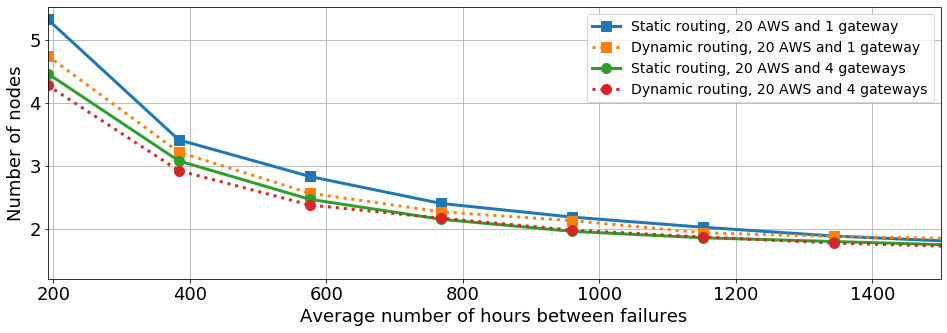

In [248]:
fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(MEAN_FAILURE_INTERVALS_3, exp_3_1a['static']['offline'], 's-', linewidth=3, markersize=10,
        label='Static routing, 20 AWS and 1 gateway')
ax.plot(MEAN_FAILURE_INTERVALS_3, exp_3_1a['dynamic']['offline'], 's:', linewidth=3, markersize=10,
        label='Dynamic routing, 20 AWS and 1 gateway')
ax.plot(MEAN_FAILURE_INTERVALS_3, exp_3_1b['static']['offline'], 'o-', linewidth=3, markersize=10,
        label='Static routing, 20 AWS and 4 gateways')
ax.plot(MEAN_FAILURE_INTERVALS_3, exp_3_1b['dynamic']['offline'], 'o:', linewidth=3, markersize=10,
        label='Dynamic routing, 20 AWS and 4 gateways')
#     ax.plot(MEAN_FAILURE_INTERVALS_2, exp_2_3b['static'][param], 'o-', 
#             label='Static routing, fast sequent repairs')
#     ax.plot(MEAN_FAILURE_INTERVALS_2, exp_2_3b['dynamic'][param], 'o--', 
#             label='Dynamic routing, fast sequent repairs')
#     ax.plot(MEAN_FAILURE_INTERVALS_2, exp_2_3c['static'][param], 'v-', 
#             label='Static routing, 4 failures are critical\nand fast sequent repairs')
#     ax.plot(MEAN_FAILURE_INTERVALS_2, exp_2_3c['dynamic'][param], 'v--', 
#             label='Dynamic routing, 4 failures are critical\nand fast sequent repairs')
ax.grid()
ax.legend(fontsize=14)
# ax.set_title(f'Average number of offline nodes')
ax.set_xlabel('Average number of hours between failures')
ax.set_xlim(left=192, right=1500)
ax.set_ylabel('Number of nodes')
fig.savefig('images/random_topology_offline.eps')
fig.savefig('images/random_topology_offline.png')